<a href="https://colab.research.google.com/github/rohts-patil/VQA-Med-2019/blob/master/notebooks/VQA_Organ_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/VQA

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/VQA


In [0]:
import glob
import random

import numpy as np
import pandas as pd

import time
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.preprocessing import LabelEncoder
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models

In [0]:
path =r'train/QAPairsByCategory'

filenames = glob.glob(path + "/*.txt")

dfs = []

for filename in filenames:
    df_temp = pd.read_csv(filename,delimiter='|',names=['id','question','answer'])
    df_temp['label'] = df_temp.apply(lambda x: ((filename.split('/')[-1].replace('_train.txt',''))), axis=1)
    dfs.append(df_temp)

df_train = pd.concat(dfs, ignore_index=True)

In [4]:
df_train.head()

,id,question,answer,label
0,synpic41148,what kind of image is this?,cta - ct angiography,C1_Modality
1,synpic43984,is this a t1 weighted image?,no,C1_Modality
2,synpic38930,what type of imaging modality is used to acqui...,us - ultrasound,C1_Modality
3,synpic52143,is this a noncontrast mri?,no,C1_Modality
4,synpic20934,what type of image modality is this?,xr - plain film,C1_Modality


In [0]:
df_train = df_train[df_train['label'] == 'C3_Organ']

In [6]:
df_train.head()

,id,question,answer,label
6400,synpic41148,which organ is captured by this ct scan?,"lung, mediastinum, pleura",C3_Organ
6401,synpic43984,what organ system is primarily present in this...,skull and contents,C3_Organ
6402,synpic38930,which organ system is imaged?,genitourinary,C3_Organ
6403,synpic52143,the mri shows what organ system?,spine and contents,C3_Organ
6404,synpic20934,what organ system is shown in this x-ray?,spine and contents,C3_Organ


In [7]:
labelencoder = LabelEncoder()
df_train['organ_type'] = labelencoder.fit_transform(df_train['answer'])
df_train.head()

,id,question,answer,label,organ_type
6400,synpic41148,which organ is captured by this ct scan?,"lung, mediastinum, pleura",C3_Organ,5
6401,synpic43984,what organ system is primarily present in this...,skull and contents,C3_Organ,7
6402,synpic38930,which organ system is imaged?,genitourinary,C3_Organ,3
6403,synpic52143,the mri shows what organ system?,spine and contents,C3_Organ,8
6404,synpic20934,what organ system is shown in this x-ray?,spine and contents,C3_Organ,8


In [9]:
integer_mapping = {l: i for i, l in enumerate(labelencoder.classes_)}
integer_mapping

{'breast': 0,
 'face, sinuses, and neck': 1,
 'gastrointestinal': 2,
 'genitourinary': 3,
 'heart and great vessels': 4,
 'lung, mediastinum, pleura': 5,
 'musculoskeletal': 6,
 'skull and contents': 7,
 'spine and contents': 8,
 'vascular and lymphatic': 9}

In [0]:
class OrganDataSet(Dataset):
    def __init__(self, image_names,organ_types, root_dir, transform=None):
        self.image_names = image_names
        self.organ_types = organ_types
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = '{}.jpg'.format(self.image_names[idx])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.organ_types[idx]
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [0]:
organ_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
train_ds = OrganDataSet(df_train['id'].values,df_train['organ_type'].values, r'train/Train_images/', transform=organ_trans)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)

In [0]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224]) torch.Size([4])


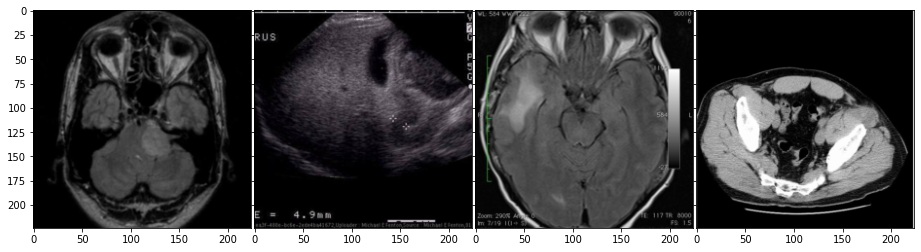

In [20]:
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])